<a href="https://colab.research.google.com/github/avani0110/ML_Assignment_1/blob/main/ml_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd

# Models and utilities
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensemble and base models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression


In [ ]:
# Load dataset
data = load_wine()
X, y = data.data, data.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 142
Testing samples: 36


In [ ]:
# Scale the features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Define base models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class="multinomial"),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate
print("=== Baseline Model Performance ===\n")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: Test Accuracy = {acc:.4f}")

# Pick best baseline (usually Random Forest)
best_model = models["Random Forest"]
print("\nClassification Report for Random Forest:\n")
print(classification_report(y_test, best_model.predict(X_test_scaled)))


=== Baseline Model Performance ===

Logistic Regression: Test Accuracy = 0.9722
Decision Tree: Test Accuracy = 0.9444


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Random Forest: Test Accuracy = 1.0000
Gradient Boosting: Test Accuracy = 0.9444

Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [ ]:
# Create a soft voting ensemble of Logistic Regression, Random Forest, and Gradient Boosting
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, multi_class="multinomial")),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ],
    voting='soft'   # average the predicted probabilities
)

# Train and test
voting_clf.fit(X_train_scaled, y_train)
y_pred_voting = voting_clf.predict(X_test_scaled)

print("=== Voting Ensemble Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("\nClassification Report:\n", classification_report(y_test, y_pred_voting))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Voting Ensemble Performance ===
Accuracy: 0.9444444444444444

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.93      0.93      0.93        14
           2       1.00      0.90      0.95        10

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36



In [ ]:
# Random Forest parameter grid
param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train_scaled, y_train)
print("Best RF Params:", grid_rf.best_params_)
print("Best RF CV Accuracy:", grid_rf.best_score_)

# Gradient Boosting parameter grid
param_gb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_gb, cv=5, scoring='accuracy')
grid_gb.fit(X_train_scaled, y_train)
print("Best GB Params:", grid_gb.best_params_)
print("Best GB CV Accuracy:", grid_gb.best_score_)


Best RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best RF CV Accuracy: 0.9862068965517242
Best GB Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best GB CV Accuracy: 0.9514778325123153


In [ ]:
# Retrieve best models
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_
best_lr = LogisticRegression(max_iter=1000, multi_class="multinomial")

# Voting classifier with tuned models
voting_tuned = VotingClassifier(
    estimators=[('lr', best_lr), ('rf', best_rf), ('gb', best_gb)],
    voting='soft'
)

voting_tuned.fit(X_train_scaled, y_train)
y_pred_tuned = voting_tuned.predict(X_test_scaled)

print("=== Tuned Voting Ensemble Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Tuned Voting Ensemble Performance ===
Accuracy: 0.9444444444444444

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.93      0.93      0.93        14
           2       1.00      0.90      0.95        10

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.95        36
weighted avg       0.95      0.94      0.94        36



In [ ]:
# Build a stacking ensemble using the tuned models
estimators = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('lr', best_lr)
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stack_model.fit(X_train_scaled, y_train)
y_pred_stack = stack_model.predict(X_test_scaled)

print("=== Stacking Ensemble Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Stacking Ensemble Performance ===
Accuracy: 0.9722222222222222

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.93      1.00      0.97        14
           2       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

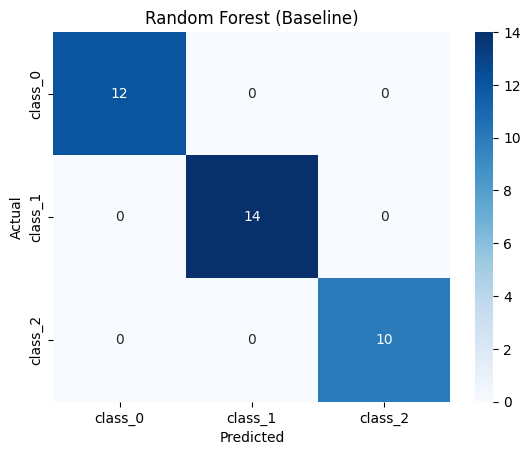

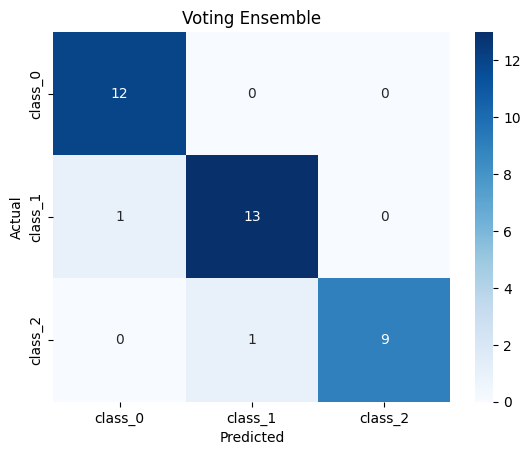

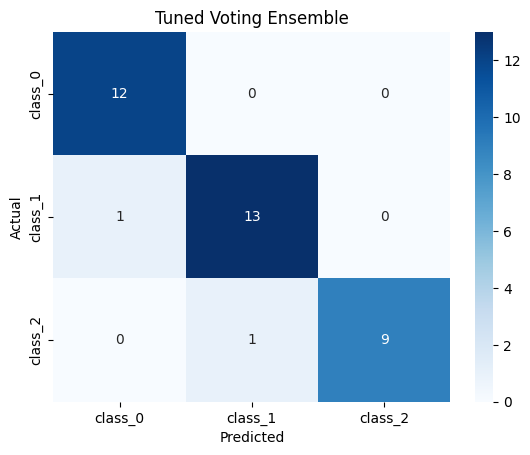

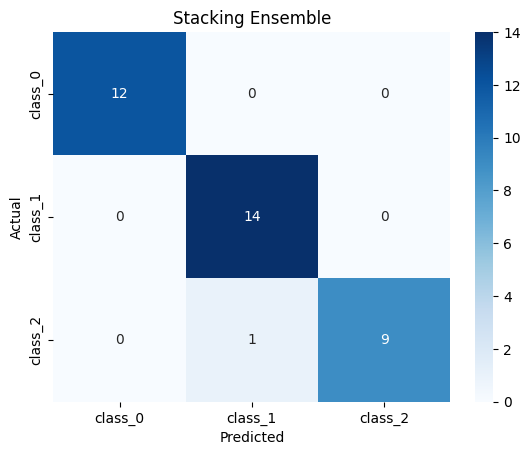

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion(y_test, best_model.predict(X_test_scaled), "Random Forest (Baseline)")
plot_confusion(y_test, y_pred_voting, "Voting Ensemble")
plot_confusion(y_test, y_pred_tuned, "Tuned Voting Ensemble")
plot_confusion(y_test, y_pred_stack, "Stacking Ensemble")


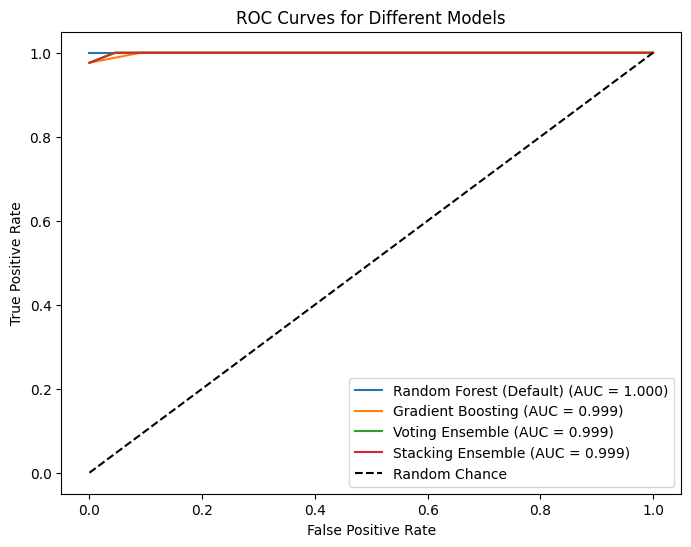

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0,1,2])
n_classes = y_test_bin.shape[1]

# Prepare models for comparison
models_roc = {
    "Random Forest (Default)": models["Random Forest"],
    "Gradient Boosting": models["Gradient Boosting"],
    "Voting Ensemble": voting_clf,
    "Stacking Ensemble": stack_model
}

plt.figure(figsize=(8,6))

# Plot ROC curve for each model (macro-average)
for name, model in models_roc.items():
    y_score = model.predict_proba(X_test_scaled)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc_macro = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {roc_auc_macro:.3f})")

# Plot formatting
plt.plot([0,1], [0,1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Different Models")
plt.legend()
plt.show()
